Reference:

- Data source:
    <https://data.worldbank.org/topic/climate-change?end=2018&start=1973>
- Custom scatterplot colors with colorbar in Matplotlib:
    <https://www.robotswillkillusall.org/posts/mpl-scatterplot-colorbar.html>
- Legend guide
    <https://matplotlib.org/users/legend_guide.html>
- Greenhouse gas
    <https://en.wikipedia.org/wiki/Greenhouse_gas>

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import branca.colormap as cm

import folium
from folium.plugins import TimeSliderChoropleth
import geopandas as gpd

In [2]:
climate_1960_2018 = pd.read_csv('datasets/climate_1960_2018.csv')
climate_1960_2018.drop(columns='Unnamed: 63', inplace=True)

In [3]:
climate_1960_2018.shape

(20064, 63)

In [4]:
indicators = ['Population, total',
              'Population growth (annual %)']

population_1960_2018 = climate_1960_2018[climate_1960_2018['Indicator Name'].isin(indicators)]
population_1960_2018.fillna(0, inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [5]:
population_1960_2018.drop(columns=['Country Code', 'Indicator Code'], inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
def df_4each_indicator(glb_df, indicator):
    df = glb_df[glb_df['Indicator Name'] == indicator]
    df.index = df['Country Name']
    df.drop(columns=['Country Name', 'Indicator Name'], inplace=True)
    df = df.T
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    return df

In [7]:
pop_tot_1960_2018 = df_4each_indicator(population_1960_2018, 'Population, total')
pop_growthPct_1960_2018 = df_4each_indicator(population_1960_2018, 'Population growth (annual %)')

In [8]:
def billions_0dec(x, pos):
    """
    :param x: value
    :param pos: tick position
    """
    return '%1.0f' % (x * 1e-9)

def billions_1dec(x, pos):
    """
    :param x: value
    :param pos: tick position
    """
    return '%1.1f' % (x * 1e-9)


FORMATTER_BILLIONS_0DEC = FuncFormatter(billions_0dec)
FORMATTER_BILLIONS_1DEC = FuncFormatter(billions_1dec)

## About population

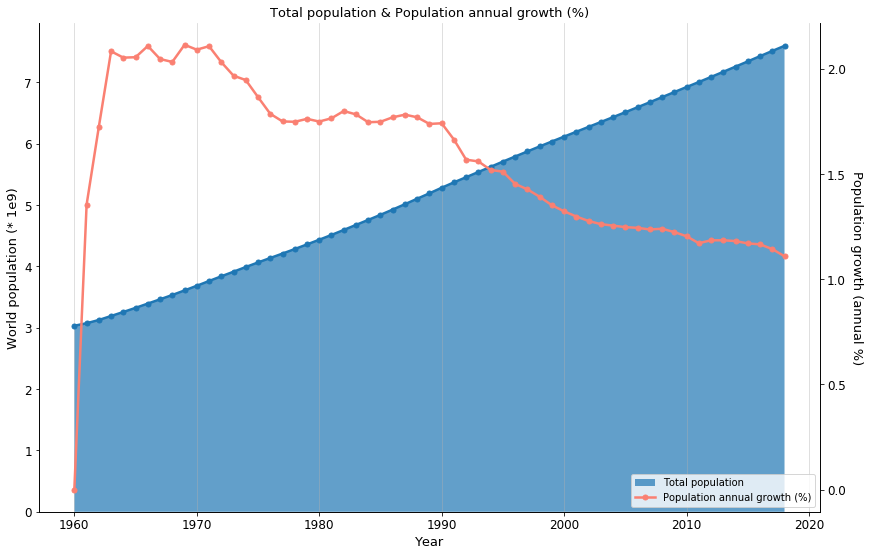

In [9]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(14, 9))
axarr.set_title('Total population & Population annual growth (%)', fontdict={'fontsize': 13})

bar_tot = axarr.fill_between(pop_tot_1960_2018.index,
                             pop_tot_1960_2018['World'],
                             alpha=0.7)

axarr.plot(pop_tot_1960_2018.index,
           pop_tot_1960_2018['World'],
           linewidth=2.5,
           marker='.',
           markersize=10)


axarr_02 = axarr.twinx()
line_pct, = axarr_02.plot(pop_growthPct_1960_2018.index,
                          pop_growthPct_1960_2018['World'],
                          color='salmon',
                          linewidth=2.5,
                          marker='.',
                          markersize=10)

axarr.tick_params(axis='both', labelsize=12)
axarr.set_xlabel('Year', size=13)
axarr.set_ylabel('World population (* 1e9)', size=13)
axarr.set_ylim(bottom=0)
axarr.yaxis.set_major_formatter(FORMATTER_BILLIONS_0DEC)
axarr.spines['top'].set_visible(False)
axarr.grid(alpha=0.5, axis='x')

axarr_02.tick_params(axis='both', labelsize=12)
axarr_02.set_ylabel('Population growth (annual %)', rotation=270, labelpad=17, size=13)
axarr_02.spines['top'].set_visible(False)
axarr_02.legend(handles=(bar_tot, line_pct),
                labels=('Total population', 'Population annual growth (%)'), loc=4)

plt.show()
# plt.savefig('population-and-growth.png', bbox_inches='tight')

The graph above describes the world's total population and population annual growth from 1960 to 2018. During nearly 60 years, total population increases 150%; especially between 1963 and 1973, the population annual growth is higher than or equal to 2%, and keeps around 1.7% annual increase until 1990, then the population increasing has slowed down since nearly 30 years, for the last 8 years, the annual increase is around 1.2%. Next, I'll specify country's population in terms of developing country and developed country.

In [10]:
imf_dvlping_ctries = ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia',
                      'Aruba', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belize',
                      'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei',
                      'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Cape Verde',
                      'Central African Republic', 'Chad', 'China', 'Chile', 'Colombia', 'Comoros',
                      'Democratic Republic of the Congo', 'Republic of the Congo', 'Costa Rica', 'Côte d\'Ivoire',
                      'Croatia', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
                      'Equatorial Guinea', 'Eritrea', 'Eswatini (Swaziland)', 'Ethiopia', 'Fiji', 'Gabon',
                      'The Gambia', 'Georgia', 'Ghana', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana',
                      'Haiti', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran', 'Iraq', 'Jamaica', 'Jordan',
                      'Kazakhstan', 'Kenya', 'Kiribati', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Lebanon',
                      'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi','Malaysia', 'Maldives', 'Mali',
                      'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Federated States of Micronesia',
                      'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru',
                      'Nepal', 'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia', 'Oman', 'Pakistan', 'Palau',
                      'Panama', 'Papua New Guinea','Paraguay', 'Peru', 'Philippines', 'Poland', 'Qatar', 'Romania',
                      'Russia', 'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines',
                      'Samoa', 'São Tomé and Príncipe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles',
                      'Sierra Leone', 'Solomon Islands', 'Somalia', 'South Africa', 'South Sudan', 'Sri Lanka',
                      'Sudan', 'Suriname', 'Syria', 'Tajikistan', 'Tanzania', 'Thailand', 'Timor-Leste', 'Togo',
                      'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda',
                      'Ukraine', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia',
                      'Zimbabwe', 'Cuba', 'North Korea', 'Palestinian territories', 'Sahrawi Arab Democratic Republic']

In [11]:
imf_dvlped_ctries = ['Lithuania', 'Latvia', 'Estonia', 'Israel', 'Slovenia', 'Czech Republic',
                     'Slovak Republic', 'Portugal', 'South Korea', 'Greece', 'New Zealand', 'Spain',
                     'Finland', 'Ireland', 'Iceland', 'United Kingdom', 'Italy', 'Sweden', 'Australia',
                     'Belgium', 'Canada', 'France', 'Luxembourg', 'Japan', 'Austria', 'Denmark',
                     'Germany', 'Netherlands', 'United States', 'Norway', 'Switzerland', 'Malta',
                     'Cyprus', 'Singapore','Puerto Rico', 'San Marino']

In [12]:
pop_tot_1960_2018.head()

Country Name,Aruba,Afghanistan,Angola,Albania,Andorra,Arab World,United Arab Emirates,Argentina,Armenia,American Samoa,Antigua and Barbuda,Australia,Austria,Azerbaijan,Burundi,Belgium,Benin,Burkina Faso,Bangladesh,Bulgaria,Bahrain,"Bahamas, The",Bosnia and Herzegovina,Belarus,Belize,Bermuda,Bolivia,Brazil,Barbados,Brunei Darussalam,Bhutan,Botswana,Central African Republic,Canada,Central Europe and the Baltics,Switzerland,Channel Islands,Chile,China,Cote d'Ivoire,Cameroon,"Congo, Dem. Rep.","Congo, Rep.",Colombia,Comoros,Cabo Verde,Costa Rica,Caribbean small states,Cuba,Curacao,Cayman Islands,Cyprus,Czech Republic,Germany,Djibouti,Dominica,Denmark,Dominican Republic,Algeria,East Asia & Pacific (excluding high income),Early-demographic dividend,East Asia & Pacific,Europe & Central Asia (excluding high income),Europe & Central Asia,Ecuador,"Egypt, Arab Rep.",Euro area,Eritrea,Spain,Estonia,Ethiopia,European Union,Fragile and conflict affected situations,Finland,Fiji,France,Faroe Islands,"Micronesia, Fed. Sts.",Gabon,United Kingdom,Georgia,Ghana,Gibraltar,Guinea,"Gambia, The",Guinea-Bissau,Equatorial Guinea,Greece,Grenada,Greenland,Guatemala,Guam,Guyana,High income,"Hong Kong SAR, China",Honduras,Heavily indebted poor countries (HIPC),Croatia,Haiti,Hungary,IBRD only,IDA & IBRD total,IDA total,IDA blend,Indonesia,IDA only,Isle of Man,India,Not classified,Ireland,"Iran, Islamic Rep.",Iraq,Iceland,Israel,Italy,Jamaica,Jordan,Japan,Kazakhstan,Kenya,Kyrgyz Republic,Cambodia,Kiribati,St. Kitts and Nevis,"Korea, Rep.",Kuwait,Latin America & Caribbean (excluding high income),Lao PDR,Lebanon,Liberia,Libya,St. Lucia,Latin America & Caribbean,Least developed countries: UN classification,Low income,Liechtenstein,Sri Lanka,Lower middle income,Low & middle income,Lesotho,Late-demographic dividend,Lithuania,Luxembourg,Latvia,"Macao SAR, China",St. Martin (French part),Morocco,Monaco,Moldova,Madagascar,Maldives,Middle East & North Africa,Mexico,Marshall Islands,Middle income,North Macedonia,Mali,Malta,Myanmar,Middle East & North Africa (excluding high income),Montenegro,Mongolia,Northern Mariana Islands,Mozambique,Mauritania,Mauritius,Malawi,Malaysia,North America,Namibia,New Caledonia,Niger,Nigeria,Nicaragua,Netherlands,Norway,Nepal,Nauru,New Zealand,OECD members,Oman,Other small states,Pakistan,Panama,Peru,Philippines,Palau,Papua New Guinea,Poland,Pre-demographic dividend,Puerto Rico,"Korea, Dem. People’s Rep.",Portugal,Paraguay,West Bank and Gaza,Pacific island small states,Post-demographic dividend,French Polynesia,Qatar,Romania,Russian Federation,Rwanda,South Asia,Saudi Arabia,Sudan,Senegal,Singapore,Solomon Islands,Sierra Leone,El Salvador,San Marino,Somalia,Serbia,Sub-Saharan Africa (excluding high income),South Sudan,Sub-Saharan Africa,Small states,Sao Tome and Principe,Suriname,Slovak Republic,Slovenia,Sweden,Eswatini,Sint Maarten (Dutch part),Seychelles,Syrian Arab Republic,Turks and Caicos Islands,Chad,East Asia & Pacific (IDA & IBRD countries),Europe & Central Asia (IDA & IBRD countries),Togo,Thailand,Tajikistan,Turkmenistan,Latin America & the Caribbean (IDA & IBRD countries),Timor-Leste,Middle East & North Africa (IDA & IBRD countries),Tonga,South Asia (IDA & IBRD),Sub-Saharan Africa (IDA & IBRD countries),Trinidad and Tobago,Tunisia,Turkey,Tuvalu,Tanzania,Uganda,Ukraine,Upper middle income,Uruguay,United States,Uzbekistan,St. Vincent and the Grenadines,"Venezuela, RB",British Virgin Islands,Virgin Islands (U.S.),Vietnam,Vanuatu,World,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
1960-01-01,54211.0,8996973.0,5454933.0,1608800.0,13411.0,92197753.0,92418.0,20481779.0,1874121.0,20123.0,54131.0,10276477.0,7047539.0,3895397.0,2797932.0,9153489.0,2431622.0,4829288.0,48013504.0,7867374.0,162427.0,109534.0,3225668.0,8198000.0,92064.0,44400.0,3656955.0,72179226.0,230980.0,81702.0,223288.0,502745.0,1501668.0,17909009.0,91401764.0,5327827.0,109420.0,8132990.0,667070000.0,3503553.0,5176918.0,15248251.0,1018253.0,16057724.0,191121.0,20

## Map

In [13]:
assert 'naturalearth_lowres' in gpd.datasets.available
datapath = gpd.datasets.get_path('naturalearth_lowres')
gdf = gpd.read_file(datapath)
gdf.rename(columns={'name':'Country'}, inplace=True)

In [14]:
gdf['Country'] = gdf['Country'].replace({'United States of America':'United States',
                                         'Bosnia and Herz.':'Bosnia and Herzegovina',
                                         'Central African Rep.':'Central African Republic',
                                         'Congo':'Congo, Rep.',
                                         'Dem. Rep. Congo':'Congo, Dem. Rep.',
                                         'Dominican Rep.':'Dominican Republic',
                                         'Egypt':'Egypt, Arab Rep.',
                                         'Iran':'Iran, Islamic Rep.',
                                         'Kyrgyzstan':'Kyrgyz Republic',
                                         'Russia':'Russian Federation',
                                         'Solomon Is.':'Solomon Islands',
                                         'Brunei':'Brunei Darussalam',
                                         'Czechia':'Czech Republic',
                                         'Eq. Guinea':'Equatorial Guinea',
                                         'S. Sudan':'South Sudan',
                                         'Slovakia':'Slovak Republic',
                                         'Syrian Arab Republic':'Syria',
                                         'Venezuela':'Venezuela, RB',
                                         'Yemen':'Yemen, Rep.',
                                         'eSwatini':'Eswatini'})

In [15]:
pop_tot_1960_2018.rename(columns={'Bahamas, The':'Bahamas',
                                  'Cote d\'Ivoire':'Côte d\'Ivoire',
                                  'Gambia, The':'Gambia',
                                  'Korea, Dem. People’s Rep.':'North Korea',
                                  'Korea, Rep.':'South Korea',
                                  'Lao PDR':'Laos',
                                  'North Macedonia':'Macedonia'}, inplace=True)

In [16]:
pop_tot_hist = pop_tot_1960_2018.stack().reset_index().rename(columns={'level_0':'Date',
                                                                       'Country Name':'Country',
                                                                       0:'Population'})
pop_2018_df = pop_tot_hist[pop_tot_hist['Date']=='2018-01-01']

In [17]:
gdf_2018 = pd.merge(gdf, pop_2018_df[['Country', 'Population']], on='Country')
gdf_2018 = gdf_2018.sort_values('Country').reset_index(drop=True)
gdf_2018 = gdf_2018[['Country', 'geometry', 'Population']]
gdf_2018['Population_k'] = gdf_2018['Population'] / 1000

In [18]:
pop_colormap_2018 = cm.LinearColormap(
    ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494'],
    vmin=min(gdf_2018['Population_k']), vmax=max(gdf_2018['Population_k'])
)

In [19]:
pop_2018_map = folium.Map(location=[0, 0], zoom_start = 2, tiles='cartodbpositron')

style_function = lambda x: {
    'fillColor': pop_colormap_2018(x['properties']['Population_k']),
    'color': 'black',
    'weight': 1,
    'fillOpacity': 0.7
}


pop_2018 = folium.GeoJson(
    gdf_2018,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['Country', 'Population_k'],
        aliases=['Country', 'Population'],
        localize=True
    )
).add_to(pop_2018_map)


pop_colormap_2018.add_to(pop_2018_map)
pop_colormap_2018.caption = 'Population ( * 1000)'
pop_colormap_2018.add_to(pop_2018_map)

In [20]:
pop_2018_map

In [21]:
# pop_2018_map.save('pop_2018_map.html')

This maps presents the population of year 2018. It's a pity that the we don't have data for some countries and regions. For the data that we have, China and India have larger population than others; the population of countries like the United States, Brazil and Russia is larger than half of other countries. Next, I'll specify country's population in terms of developing country and developed country.

## Developing countries

In [22]:
dvlping_ctries_pop_hist = pop_tot_1960_2018[
    pop_tot_1960_2018.columns[pop_tot_1960_2018.columns.isin(imf_dvlping_ctries)==True]]

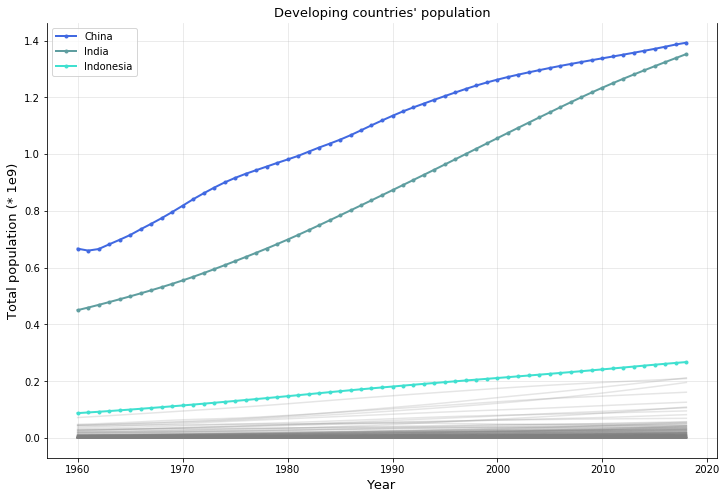

In [23]:
dvlping_ctries_pop18_top3 = ['China', 'India', 'Indonesia']

fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

axarr.set_title('Developing countries\' population', fontdict={'fontsize': 13})

for col in dvlping_ctries_pop_hist.drop(columns=dvlping_ctries_pop18_top3).columns:
    axarr.plot(dvlping_ctries_pop_hist.index,
              dvlping_ctries_pop_hist[col],
              label=col,
              color='gray',
              alpha=0.2)

pop_cn, = axarr.plot(dvlping_ctries_pop_hist.index,
                     dvlping_ctries_pop_hist['China'],
                     color='royalblue',
                     marker='.',
                     linewidth=2)
pop_in, = axarr.plot(dvlping_ctries_pop_hist.index,
                     dvlping_ctries_pop_hist['India'],
                     color='cadetblue',
                     marker='.',
                     linewidth=2)
pop_id, = axarr.plot(dvlping_ctries_pop_hist.index,
                     dvlping_ctries_pop_hist['Indonesia'],
                     color='turquoise',
                     marker='.',
                     linewidth=2)

axarr.set_xlabel('Year', size=13)
axarr.set_ylabel('Total population (* 1e9)', size=13)
axarr.yaxis.set_major_formatter(FORMATTER_BILLIONS_1DEC)
axarr.legend(handles=[pop_cn, pop_in, pop_id], loc=2)
axarr.spines['top'].set_visible(False)
axarr.grid(alpha=0.3)

plt.show()
# plt.savefig('population-developing-countries.png', bbox_inches='tight')

Among developing countries, the top 3 countries in terms of population are China, India and Indonesia. The gap between Chinese population and Indian population is increasingly smaller, the population of Indonesia is far from the population of India.

### China
<https://en.wikipedia.org/wiki/China#Demographics><br>
Given concerns about population growth, China implemented a two-child limit during the 1970s, and, in 1979, began to advocate for an even stricter limit of one child per family. Beginning in the mid 1980s, however, given the unpopularity of the strict limits, China began to allow some major exemptions, particularly in rural areas, resulting in what was actually a "1.5"-child policy from the mid-1980s to 2015 (ethnic minorities were also exempt from one child limits). The next major loosening of the policy was enacted in December 2013, allowing families to have two children if one parent is an only child. In 2016, the one-child policy was replaced in favor of a two-child policy. Data from the 2010 census implies that the total fertility rate may be around 1.4, although due to underreporting of births it may be closer to 1.5–1.6.

According to one group of scholars, one-child limits had little effect on population growth or the size of the total population. However, these scholars have been challenged. Their own counterfactual model of fertility decline without such restrictions implies that China averted more than 500 million births between 1970 and 2015, a number which may reach one billion by 2060 given all the lost descendants of births averted during the era of fertility restrictions, with one-child restrictions accounting for the great bulk of that reduction.

### India
<https://en.wikipedia.org/wiki/India#Demographics,_languages,_and_religion><br>
With 1,210,193,422 residents reported in the 2011 provisional census report, India is the world's second-most populous country. Its population grew by 17.64% during 2001–2011, compared to 21.54% growth in the previous decade (1991–2001). The human sex ratio, according to the 2011 census, is 940 females per 1,000 males. The median age was 27.6 as of 2016. The first post-colonial census, conducted in 1951, counted 361.1 million people. Medical advances made in the last 50 years as well as increased agricultural productivity brought about by the "Green Revolution" have caused India's population to grow rapidly. India continues to face several public health-related challenges.

### Indonesia
<https://en.wikipedia.org/wiki/Indonesia#Demographics><br>
The 2010 census recorded Indonesia's population as 237.6 million, with high population growth at 1.9%.58% of the population lives in Java, the world's most populous island. The population density is 138 people per km2 (357 per sq mi), ranking 88th in the world, although Java has a population density of 1,067 people per km2 (2,435 per sq mi). The spread of the population is uneven throughout the islands with a varying habitat and level of development, ranging from the megalopolis of Jakarta to uncontacted tribes in Papua. In 1961, the first post-colonial census recorded a total of 97 million people. It is expected to grow to around 295 million by 2030 and 321 million by 2050. The country currently possesses a relatively young population, with a median age of 30.2 years (2017 estimate). About 8 million Indonesians live overseas; most settled in Malaysia, Netherlands, Saudi Arabia, United Arab Emirates, Hong Kong, Singapore, the United States, and Australia.

## Developed countries

In [24]:
dvlped_ctries_pop_hist = pop_tot_1960_2018[
    pop_tot_1960_2018.columns[pop_tot_1960_2018.columns.isin(imf_dvlped_ctries)==True]]

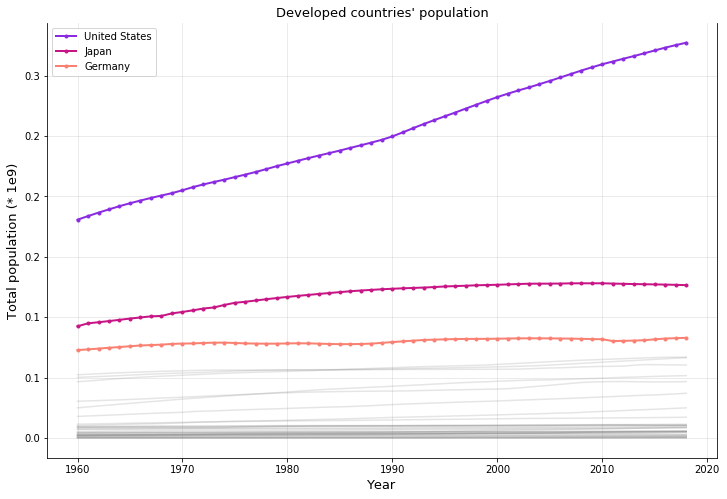

In [25]:
dvlped_ctries_pop18_top3 = ['United States', 'Japan', 'Germany']

fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

axarr.set_title('Developed countries\' population', fontdict={'fontsize': 13})

for col in dvlped_ctries_pop_hist.drop(columns=dvlped_ctries_pop18_top3).columns:
    axarr.plot(dvlped_ctries_pop_hist.index,
              dvlped_ctries_pop_hist[col],
              label=col,
              color='gray',
              alpha=0.2)

pop_us, = axarr.plot(dvlped_ctries_pop_hist.index,
                     dvlped_ctries_pop_hist['United States'],
                     color='blueviolet',
                     marker='.',
                     linewidth=2)
pop_jp, = axarr.plot(dvlped_ctries_pop_hist.index,
                     dvlped_ctries_pop_hist['Japan'],
                     color='mediumvioletred',
                     marker='.',
                     linewidth=2)
pop_de, = axarr.plot(dvlped_ctries_pop_hist.index,
                     dvlped_ctries_pop_hist['Germany'],
                     color='salmon',
                     marker='.',
                     linewidth=2)

axarr.set_xlabel('Year', size=13)
axarr.set_ylabel('Total population (* 1e9)', size=13)
axarr.yaxis.set_major_formatter(FORMATTER_BILLIONS_1DEC)
axarr.legend(handles=[pop_us, pop_jp, pop_de], loc=2)
axarr.spines['top'].set_visible(False)
axarr.grid(alpha=0.3)

plt.show()
# plt.savefig('population-developed-countries.png', bbox_inches='tight')

Among developed countries, the top 3 countries in terms of population are United States, Japan and Germany. The population of the United States increase continuously, so that it gets much much beyond Japan and Germany; however, the population of Japan and Germany have kept nearly constant since 1990.

### United States
<https://en.wikipedia.org/wiki/United_States#Demographics><br>
The U.S. Census Bureau estimated the country's population to be 327,167,434 as of July 1, 2018, and to be adding 1 person (net gain) every 13 seconds, or about 6,646 people per day.The U.S. population almost quadrupled during the 20th century, from 76.2 million in 1900 to 281.4 million in 2000. The third most populous nation in the world, after China and India, the United States is the only major industrialized nation in which large population increases are projected. In the 1800s the average woman had 7.04 children; by the 1900s this number had decreased to 3.56. Since the early 1970s the birth rate has been below the replacement rate of 2.1 with 1.76 children per woman in 2017. Foreign-born immigration has caused the U.S. population to continue its rapid increase with the foreign-born population doubling from almost 20 million in 1990 to over 45 million in 2015, representing one-third of the population increase. In 2018, there were almost 90 million immigrants and U.S.-born children of immigrants (second-generation Americans) in the United States, accounting for 28% of the overall U.S. population. The United States has a very diverse population; 37 ancestry groups have more than one million members. German Americans are the largest ethnic group (more than 50 million) – followed by Irish Americans (circa 37 million), Mexican Americans (circa 31 million) and English Americans (circa 28 million).

White Americans (mostly European ancestry group with 73.1% of total population) are the largest racial group; black Americans are the nation's largest racial minority (note that in the U.S. Census, Hispanic and Latino Americans are counted as an ethnic group, not a "racial" group), and third-largest ancestry group. Asian Americans are the country's second-largest racial minority; the three largest Asian American ethnic groups are Chinese Americans, Filipino Americans, and Indian Americans. According to a 2015 survey, the largest American community with European ancestry is German Americans, which consists of more than 14% of the total population. In 2010, the U.S. population included an estimated 5.2 million people with some American Indian or Alaska Native ancestry (2.9 million exclusively of such ancestry) and 1.2 million with some native Hawaiian or Pacific island ancestry (0.5 million exclusively). The census counted more than 19 million people of "Some Other Race" who were "unable to identify with any" of its five official race categories in 2010, over 18.5 million (97%) of whom are of Hispanic ethnicity.

### Japan
<https://en.wikipedia.org/wiki/Japan#Demographics><br>
Japan is the second most populous island country with a population of 126.3 million (2019). 124.8 million are Japanese nationals (2019). Honshū is the world's 2nd most populous island and it has 80% of Japan's population. Due to the rugged and mountainous terrain with 66% forest, the population is clustered in urban areas on the coast, plains and valleys. Japan is an urban society with only 5% of the labor force working in agriculture. About 80 million of the urban population is heavily concentrated on the Pacific coast of Honshu. In 2010, 90.7% of the total Japanese population lived in cities.

The capital city Tokyo has a population of 13.8 million (2018). It is part of the Greater Tokyo Area, the biggest metropolitan area in the world with 38,140,000 people (2016). The area is 13,500 km2 (5,200 sq mi) and the metro area has a population density of 2,642/km2.

### Germany
<https://en.wikipedia.org/wiki/Germany#Demographics><br>
With a population of 80.2 million according to the 2011 census, rising to at least 81.9 million as of 31 December 2015, Germany is the most populous country in the European Union, the second most populous country in Europe after Russia, and the 16th most populous country in the world. Its population density stands at 227 inhabitants per square kilometre (588 per square mile). The overall life expectancy in Germany at birth is 80.19 years (77.93 years for males and 82.58 years for females). The fertility rate of 1.41 children born per woman (2011 estimates), below the replacement rate of 2.1, it remains considerably below the high of 5.28 children born per woman in 1884, or 8.33 births per 1000 inhabitants, is one of the lowest fertility rates in the world. Since the 1970s, Germany's death rate has exceeded its birth rate. However, Germany is witnessing increased birth rates and migration rates since the beginning of the 2010s, particularly a rise in the number of well-educated migrants. Germany has the 3rd oldest population in the world, with the average age of 47.4 years.

Four sizeable groups of people are referred to as "national minorities" because their ancestors have lived in their respective regions for centuries: There is a Danish minority (about 50,000) in the northernmost state of Schleswig-Holstein; the Sorbs, a Slavic population of about 60,000, are in the Lusatia region of Saxony and Brandenburg.; the Roma and Sinti live throughout country; and the Frisians are concentrated in Schleswig-Holstein's western coast and in the north-western part of Lower Saxony.

Approximately 5 million Germans live abroad (Auslandsdeutsche).